In [199]:
import numpy as np
import glob
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
from skimage import io
from skimage import transform
import tensorflow as tf

%matplotlib inline

DATA_DIR = "/Users/ivanitz/Data/the-simpsons-characters-dataset/"
IMG_SIZE = 128

In [200]:
map_characters = {
        0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
    }

In [201]:
def load_pictures(max_per_classs):
    pics = []
    labels = []
    for l, c in map_characters.items():
        pictures = glob.glob(os.path.join(DATA_DIR, 'simpsons_dataset', "{}".format(c), "*"))
        for idx in tqdm(range(len(pictures)), desc="Loading {}".format(c)):
            if idx >= max_per_classs:
                break
            img = io.imread(pictures[idx])
            img = transform.resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True).astype(np.uint8)
            img = img.astype(np.uint8)
            pics.append(img)
            labels.append(l)
    return np.array(pics, dtype=np.uint8), np.array(labels, dtype=np.uint8) 

In [202]:
pics, labels = load_pictures(10)

Loading sideshow_bob:   1%|          | 10/877 [00:00<00:09, 96.19it/s]


In [141]:
print("Images shape:")
print(pics.shape)

Images shape:
(1800, 128, 128, 3)


In [142]:
def show_random(pics, labels):
    N, _, _, _ = pics.shape
    idx = np.random.choice(range(N)) 
    plt.imshow(pics[idx])
    plt.title(map_characters[labels[idx]])
    plt.show()

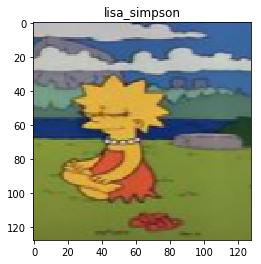

In [289]:
show_random(pics, labels)

In [146]:
def get_one_hot_encoding(labels, num_classes):
    N, = labels.shape
    M = len(np.unique(labels))
    
    ret = np.zeros((N, M))
    ret[np.arange(len(labels)), labels] = 1

    return ret

In [147]:
labels_hot = get_one_hot_encoding(labels, 1)

## Defining model

In [151]:
H, W, C = (128, 128, 3)
NUM_CLASSES = 18

In [160]:
def load_model():
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.uint8, shape=[None, H, W, 3], name="x")
    y = tf.placeholder(tf.uint8, shape=[None, NUM_CLASSES], name="y")
    
    is_training = tf.placeholder_with_default(False, shape=(), name='is_training')
    
    init = tf.contrib.layers.xavier_initializer()
    
    out = tf.divide(x, 255)
    
    out = tf.layers.conv2d(out, filters=16, kernel_size=[3,3], activation=tf.nn.elu, kernel_initializer=init, padding="same")
    out = tf.layers.max_pooling2d(out, pool_size=(2, 2), strides=[2,2])
    
    out = tf.layers.conv2d(out, filters=32, kernel_size=[3,3], activation=tf.nn.elu, kernel_initializer=init, padding="same")
    out = tf.layers.max_pooling2d(out, pool_size=(2, 2), strides=[2,2])
    
    out = tf.layers.conv2d(out, filters=64, kernel_size=[3,3], activation=tf.nn.elu, kernel_initializer=init, padding="same")
    out = tf.layers.max_pooling2d(out, pool_size=(2, 2), strides=[2,2])
    
    out = tf.contrib.layers.flatten(out)
    
    out = tf.layers.dense(out, units=512, activation=tf.nn.relu, kernel_initializer=init)
    
    out = tf.layers.dense(out, units=NUM_CLASSES, kernel_initializer=init)
    
    return x, y, is_training, out

In [247]:
def load_loss(y, out):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out, name="loss")
    loss = tf.reduce_mean(loss)
    return loss

In [248]:
def load_trainer(loss):
    opt = tf.train.AdamOptimizer()
    return opt.minimize(loss)

In [249]:
def register_scalars(m):
    for k, v in m.items():
        tf.summary.scalar(k, v)

In [250]:
def trainable_parameters():
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    return total_parameters

In [251]:
x, y, is_training, out = load_model()
loss = load_loss(y, out)
upd = load_trainer(loss)

In [252]:
register_scalars({"loss": loss})

info = tf.summary.merge_all()

In [253]:
print(trainable_parameters())

8421938


# Train model

In [254]:
def load_session():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    return sess

In [255]:
def train(sess, pics, labels_hot, epochs, batch_size, train_writer):
    N, _, _, _ = pics.shape
    idxs = np.arange(N)
    
    i=0

    for ep in tqdm(range(epochs)):
        np.random.shuffle(idxs)

        for b in range(0, N, batch_size):
            X_batch = pics[b:b+batch_size]
            Y_batch = labels_hot[b:b+batch_size]

            if X_batch.shape[0] < BATCH_SIZE:
                break

            graph_info, _ = sess.run([info, upd], feed_dict={x: X_batch, y: Y_batch, is_training: True})
            train_writer.add_summary(graph_info, i)
            i+=1

In [256]:
def predict(img):
    img_batch = np.reshape(img, [1, H, W, 3])
    graph_out, = sess.run([out], feed_dict={x: img_batch})
    char = np.argmax(np.squeeze(graph_out))
    plt.imshow(img)
    plt.title(map_characters[char])
    plt.show()

### Overfitting data first

In [257]:
pics, labels = load_pictures(10)
labels_hot = get_one_hot_encoding(labels, num_classes=np.max(labels))

Loading sideshow_bob:   1%|          | 9/877 [00:00<00:10, 84.40it/s]


In [258]:
print(pics.shape)
print(labels_hot.shape)

(180, 128, 128, 3)
(180, 18)


In [263]:
EPOCHS = 100
BATCH_SIZE = 32
LOGS_DIR = "logs"


sess = load_session()
writer = tf.summary.FileWriter(os.path.join(LOGS_DIR, "train"), graph=sess.graph)

train(sess, pics, labels_hot, EPOCHS, BATCH_SIZE, writer)

100%|██████████| 100/100 [04:59<00:00,  3.00s/it]


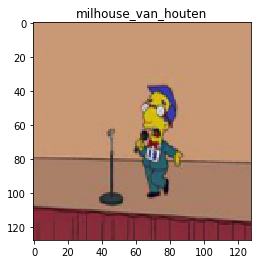

In [285]:
idx = np.random.choice(pics.shape[0])
predict(pics[idx])